In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treecorr
import healpy as hp
import os

from importlib import reload

import somoclu

import time

start_time = time.time()

import sys
sys.path.append('src')

In [2]:
GETBACK=sys.path

In [3]:
current_path = os.getcwd()  # Obtiene el directorio actual
parent_path = os.path.dirname(current_path)  # Sube un nivel
os.chdir(parent_path)  # Cambia al directorio padre
sys.path = os.getcwd()

In [4]:
GETBACK2=sys.path

In [5]:
catwo = pd.read_parquet("property_maps_desy3_small.parquet.gzip")
catwo = catwo.drop(['HPIX_4096','FOREGROUND_MASK','BADREGIONS_MASK','EBV_SFD98'], axis=1)
catwo = catwo.iloc[0:0]

In [6]:
sys.path=GETBACK2
os.chdir("Modulos")

In [7]:
MainArray = np.loadtxt("Main_Parmeters.txt")

In [8]:
som_dim = int(MainArray[0])
JoyDiv=int(MainArray[1])
dif=int(MainArray[2])
JD=int(MainArray[3])
SJ=int(MainArray[4])
Bin=0

del MainArray

In [9]:
cat = pd.read_parquet("property_maps_desy3PIX.parquet.gzip")

In [10]:
MagicianRed = pd.read_parquet("MagicianRedFULL.parquet.gzip")

In [11]:
nside = 4096
npix = hp.pixelfunc.nside2npix(nside)
ipix_mask = np.arange(npix)[cat['HPIX_4096']]

#N = len(redmagic_df[redmagic_df['bin_id']==0])
N = len(MagicianRed)

random_ra = np.empty(0)
random_dec = np.empty(0)

factor = 100

while len(random_ra) < factor * N:
    #print(len(random_ra)/(factor * N))
    # How to generate a random catalog in a sphere:
    #Nrandom = int(len(redmagic_df)) * 10 # 10x the number of data points.
    Nrandom = int(len(MagicianRed)) * 10
    ra_min, ra_max = min(MagicianRed['ra']), max(MagicianRed['ra'])
    dec_min, dec_max = min(MagicianRed['dec']), max(MagicianRed['dec'])
    _random_ra = np.random.uniform(ra_min, ra_max, Nrandom)
    
    # random_ra = np.where(random_ra > 0.0, random_ra, random_ra +360)
    _random_dec = (180/np.pi) * np.arcsin(
        np.random.uniform(
            np.sin(dec_min * np.pi/180),
            np.sin(dec_max * np.pi/180),
             Nrandom
        )
    )
        
    _random_pix = hp.ang2pix(nside, _random_ra, _random_dec, lonlat=True, nest=1)
    # Here is where you would mask by foreground, badregion, etc. 
    _msk = np.isin(_random_pix, ipix_mask)
    _random_ra = _random_ra[_msk]
    _random_dec = _random_dec[_msk]
    random_ra = np.concatenate((random_ra, _random_ra))
    random_dec = np.concatenate((random_dec, _random_dec))


print((random_ra))
print((random_dec))

[ 45.07730216  42.95016829 -32.51359327 ... -38.08365748  83.02547785
  12.37933863]
[ -9.59484973  -4.41864749  -0.99622854 ... -46.33224199 -30.82713483
 -62.4131049 ]


In [12]:
sys.path=GETBACK

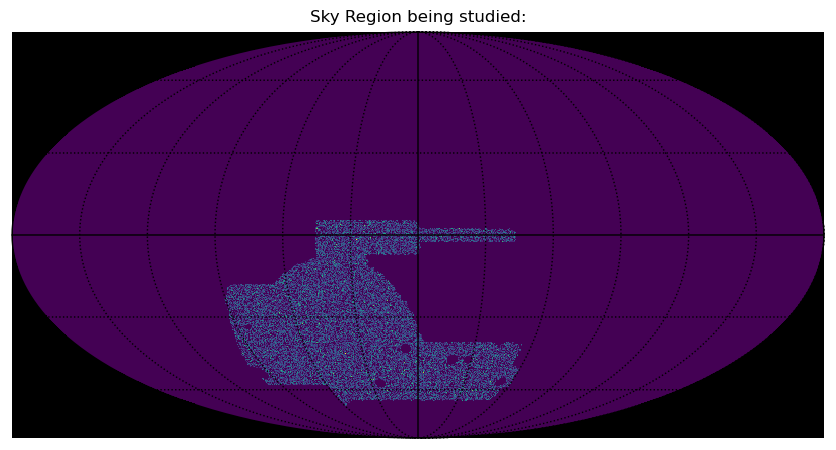

In [13]:
hpix = hp.pixelfunc.ang2pix(nside, random_ra, random_dec, nest=True, lonlat=True)

map_d = np.zeros(hp.nside2npix(nside)) 

np.add.at(map_d, hpix, 1.0) 
 
hp.mollview(map_d,nest=1,title="Sky Region being studied:",cbar=False, bgcolor='black') 
hp.graticule()
plt.show()

In [14]:
sys.path=GETBACK2

In [15]:
ra_data=MagicianRed['ra']
dec_data=MagicianRed['dec']

In [16]:
#data_catalog = treecorr.Catalog(ra=ra_data, dec=dec_data, ra_units='deg', dec_units='deg')
weighted_catalog = treecorr.Catalog(ra=ra_data, dec=dec_data, ra_units='deg', dec_units='deg', w=MagicianRed['NewWeights'].values)
rand_catalog = treecorr.Catalog(ra=random_ra, dec=random_dec, ra_units='deg', dec_units='deg')
#weighted_catalog = treecorr.Catalog(ra=ra_data, dec=dec_data, ra_units='deg', dec_units='deg', w=MagicianRed['NewWeights'].values)


In [17]:
config = {"min_sep": 6, "max_sep": 200, "nbins":20, "sep_units":"arcmin"}

In [ ]:
dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)

dd.process(weighted_catalog)
dr.process(weighted_catalog, rand_catalog)
rr.process(rand_catalog)

xi1, varxi1 = dd.calculateXi(rr=rr, dr=dr)

In [ ]:
np.savetxt("Xi2.txt", xi1, fmt="%.15f")
np.savetxt("VarXi2.txt", varxi1, fmt="%.15f")

In [ ]:
xi2=np.loadtxt("Xi.txt")

In [ ]:
plt.plot(dd.rnom, xi2*dd.rnom, marker='.', ls='-')
plt.plot(dd.rnom, xi1*dd.rnom, marker='.', ls='--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$\theta$ [arcmin]")
plt.ylabel(r"$\theta * w(\theta)$")
plt.show()